In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.display import Image
from IPython.core.display import Image, display
import numpy as np

batch_size = 100

In [109]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive/results3/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [111]:
import zipfile
from PIL import Image
import torchvision.transforms.functional as TF

np.random.seed(0)

archive = zipfile.ZipFile('/gdrive/My Drive/2019Fall/images_labeled.zip', 'r')

pick_number = 5000
shoes_images = torch.tensor(np.empty([pick_number, 3, 136, 136])).type(torch.DoubleTensor)
print(shoes_images.size())


picked_list = np.random.choice(50000, pick_number, replace=False)
print(picked_list)

torch.Size([5000, 3, 136, 136])
[11841 19602 45519 ... 12143 34963 23333]


In [112]:
#print(archive.namelist())
for i in range(pick_number):
  
  imgfile = archive.open('images/' + str(picked_list[i]+1) + '.jpg')
  imgfile = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor)
  
  if(imgfile.size(1)!=136 or imgfile.size(2)!=136):
    print("nono..")
    continue
  shoes_images[i] = imgfile

print(shoes_images.size())

torch.Size([5000, 3, 136, 136])


In [0]:
shoes_dataloader = torch.utils.data.DataLoader(dataset=shoes_images,
                                              batch_size=batch_size,
                                              shuffle=False)

torch.Size([16, 3, 136, 136])
torch.DoubleTensor


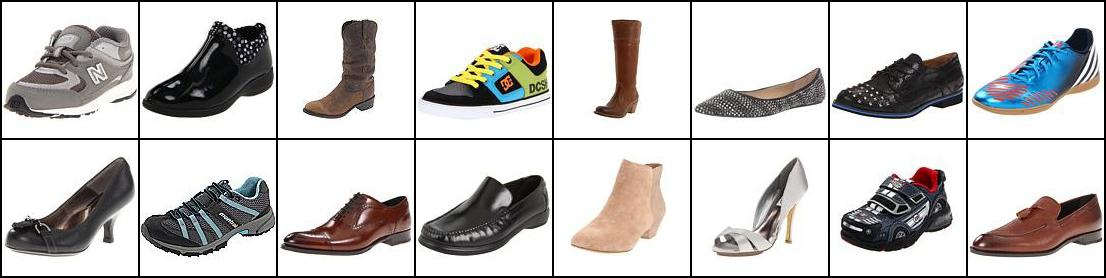

In [114]:
from IPython.display import Image
from IPython.core.display import Image, display

fixed_x = next(iter(shoes_dataloader))
recon_test_data = fixed_x[0:16]

# channels is 3 (R, G, B)
image_channels = fixed_x.size(1)
print(recon_test_data.size())
print(recon_test_data.type())
save_image(recon_test_data, 'temp.jpg')
Image('temp.jpg')

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 40, 6, 6)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_channels, h_dim=36*40, z_dim=100):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 6, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(6, 12, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 30, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(30, 40, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
             UnFlatten(),
             nn.ConvTranspose2d(40, 30, kernel_size=3, stride=2),
             nn.ReLU(),
             nn.ConvTranspose2d(30, 24, kernel_size=4, stride=1),
             nn.ReLU(), 
             nn.ConvTranspose2d(24, 12, kernel_size=3, stride=2),    
             nn.ReLU(), 
             nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2),  
             nn.ReLU(), 
             nn.ConvTranspose2d(6, image_channels, kernel_size=4, stride=2),  
             nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [118]:
print(len(fixed_x))
model = VAE(image_channels=image_channels).type('torch.DoubleTensor').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100


In [0]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_loss = 999999999
ckpt_path = os.path.join(ckpt_dir, 'shoes_model.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['VAE_model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_loss = ckpt['best_loss']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best loss : %.2f' % best_loss)

In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 55488), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + 1000*KLD, BCE, 1000*KLD

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss1 = 0
    train_loss2 = 0
    for batch_idx, data in enumerate(shoes_dataloader):
        data = data.to(device).double()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data.double())
        loss, loss1, loss2 = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(shoes_dataloader.dataset),
                100. * batch_idx / len(shoes_dataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(shoes_dataloader.dataset)))
    return train_loss/len(shoes_dataloader.dataset), train_loss1/len(shoes_dataloader.dataset), train_loss2/len(shoes_dataloader.dataset)

In [122]:
from IPython.core.display import Image, display

loss1_list = []
loss2_list = []

for epoch in range(1, 1000):
    train_loss, loss1, loss2 = train(epoch)
    loss1_list.append(loss1)
    loss2_list.append(loss2)
    #test_loss = test(epoch)
    print(int(train_loss), int(best_loss), int(loss1), int(loss2))
    # save checkpoint whenever there is improvement in performance
    if train_loss < best_loss:
      best_loss = train_loss
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'VAE_model':model.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_loss':best_loss}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    if epoch % 5 == 0 :
      with torch.no_grad():
          print("**************")
          print("saving image..")
          print("**************")
          a, b, c = model.forward(recon_test_data.view(16, 3, 136, 136).to(device))
          save_image(a.view(16, 3, 136, 136), gdrive_root + 'recon_sample_' + str(epoch) + '.png')

          sample = torch.randn(16, 100).type('torch.DoubleTensor').to(device)
          sample = model.decode(sample).cpu()
          save_image(sample.view(16, 3, 136, 136),
                      gdrive_root + 'sample_' + str(epoch) + '.png')

Train Epoch: 896 [1000/5000 (20%)]		 Loss: 14938.823469
Train Epoch: 896 [2000/5000 (40%)]		 Loss: 14967.070914
Train Epoch: 896 [3000/5000 (60%)]		 Loss: 15308.795334
Train Epoch: 896 [4000/5000 (80%)]		 Loss: 14553.927534
====> Epoch: 896 Average loss: 15145.7868
15145 15132 13618 1527
Train Epoch: 897 [0/5000 (0%)]		 Loss: 15079.939325
Train Epoch: 897 [1000/5000 (20%)]		 Loss: 14803.696519
Train Epoch: 897 [2000/5000 (40%)]		 Loss: 14966.791204
Train Epoch: 897 [3000/5000 (60%)]		 Loss: 15363.257504
Train Epoch: 897 [4000/5000 (80%)]		 Loss: 14916.651582
====> Epoch: 897 Average loss: 15178.3948
15178 15132 13611 1567
Train Epoch: 898 [0/5000 (0%)]		 Loss: 15204.797417
Train Epoch: 898 [1000/5000 (20%)]		 Loss: 14984.563864
Train Epoch: 898 [2000/5000 (40%)]		 Loss: 14862.456398
Train Epoch: 898 [3000/5000 (60%)]		 Loss: 15173.073156
Train Epoch: 898 [4000/5000 (80%)]		 Loss: 15009.191081
====> Epoch: 898 Average loss: 15183.2423
15183 15132 13617 1566
Train Epoch: 899 [0/5000 (0%)

In [123]:
print(loss1_list)
print(loss2_list)

[35207.82090758966, 23737.005222785534, 18476.412143019304, 17487.220915536294, 16707.616476962543, 16304.260005985156, 16082.546187993994, 16002.107821556443, 15967.642130133614, 15880.80989858939, 15817.378259871, 15792.303791493116, 15776.201232015275, 15735.78468546963, 15708.100856553787, 15698.764808899683, 15658.670216804103, 15646.916654924491, 15591.29356953694, 15544.254755635478, 15501.108481573992, 15453.259284694008, 15495.306740443235, 15450.836199324172, 15377.690437578416, 15263.493087522947, 15192.459547555807, 15074.51466223949, 15019.693129771284, 14963.788467369459, 14905.0745474977, 14898.677219833502, 14849.055196973059, 14847.256759392085, 14800.953115381997, 14777.275927235642, 14754.902825649213, 14740.085569691106, 14711.231831220355, 14701.955188400698, 14683.175745306185, 14717.311299732002, 14645.113333680407, 14622.57929557742, 14607.421708501708, 14601.840446954902, 14567.260235102192, 14569.392271341108, 14555.04272987456, 14525.724354312866, 14482.98202

In [0]:
import csv

f = open(gdrive_root + '/file_name.csv', 'w', encoding='utf-8')
wr = csv.writer(f)

for i, data in enumerate(shoes_dataloader):
  data = data.to(device)
  z, _, _ = model.type('torch.cuda.DoubleTensor').encode(data)
  for line in z.tolist():
    wr.writerow(line)

f.close()

  #if (i+1) % 5 == 0 :
  #  break
# index, channel, 가로, 세로

input your index :1
original image


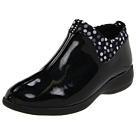

recommend image


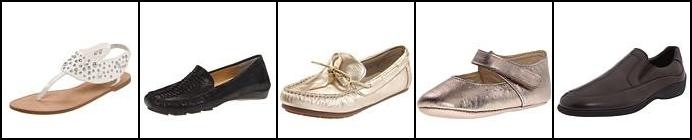

input your index :2
original image


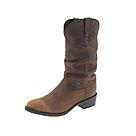

recommend image


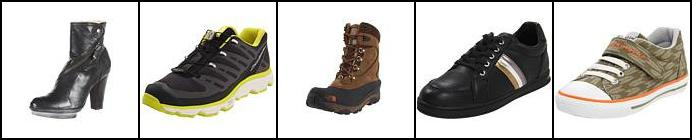

KeyboardInterrupt: ignored

In [125]:
while True :
  search_index = int(input("input your index :"))
  base = []

  recommend_value = [10000, 10001, 10002, 10003, 10004]
  recommend_index = [0, 0, 0, 0, 0]

  f = open(gdrive_root + '/file_name.csv', 'r', encoding='utf-8')
  rdr = csv.reader(f)

  i=0
  for line in rdr:
    if i == search_index :
      base = line
      break
    i += 1

  base = np.array([float(i) for i in base])

  # 처음부터 읽기 위해서 다시 open 해야 함
  f.close()
  f = open(gdrive_root + '/file_name.csv', 'r', encoding='utf-8')

  # 가장 가까운 5개 찾기
  k = 0
  rdr = csv.reader(f)
  for line in rdr:

    # 자기 자신은 제외하고 검색
    if k == search_index :
      k = k + 1
      continue

    now = np.array([float(i) for i in line])
    now_value = np.linalg.norm(base-now)
    
    flag = 0
    before = len(recommend_value) - 1
    
    for i in range(len(recommend_value)):
      if recommend_value[4-i] > now_value :
        if flag == 0:
          recommend_value[4-i] = now_value
          recommend_index[4-i] = k
          flag = 1
        else :
          recommend_value[4-i] ,recommend_value[before] = recommend_value[before], recommend_value[4-i]
          recommend_index[4-i] ,recommend_index[before] = recommend_index[before], recommend_index[4-i]
        before = 4 - i
    k = k + 1

  f.close()

  #print(recommend_value)
  #print(recommend_index)

  from PIL import Image
  from IPython.core.display import Image as Image_show
  from IPython.core.display import display

  imgfile = archive.open('images/' + str(picked_list[search_index]+1) + '.jpg')
  imgfile = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor).view(1, 3, 136, 136)
  print("original image")
  save_image(imgfile, 'temp.jpg')
  display(Image_show('temp.jpg'))

  img_list = torch.tensor(np.empty([5, 3, 136, 136])).type(torch.DoubleTensor)

  for i in range(len(recommend_value)):
    
    imgfile = archive.open('images/' + str(picked_list[recommend_index[i]]+1) + '.jpg')
    img_list[i] = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor).view(3, 136, 136)

  save_image(img_list, 'temp.jpg')
  print("recommend image")
  display(Image_show('temp.jpg'))